# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# UNET Architecture

In [ ]:
class DoubleConv(nn.Module):
    """Double convolution: (conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    """UNet architecture for image segmentation"""
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConv(feature*2, feature))
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip = skip_connections[idx//2]
            
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            
            x = torch.cat([skip, x], dim=1)
            x = self.decoder[idx+1](x)
        
        return torch.sigmoid(self.final_conv(x))

# DATASET

In [ ]:
class SegmentationDataset(Dataset):
    """Dataset for loading images and segmentation masks"""
    def __init__(self, image_dir, mask_dir, transform=None, img_size=256):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        mask_name = img_name
        if not os.path.exists(os.path.join(self.mask_dir, mask_name)):
            base_name = os.path.splitext(img_name)[0]
            mask_name = base_name + '.png'
        
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        image = image.resize((self.img_size, self.img_size))
        mask = mask.resize((self.img_size, self.img_size))
        
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])(image)
        
        return image, mask

# TRAINING

In [ ]:
def train_model(model, train_loader, val_loader, device, num_epochs=25, lr=1e-4):
    """Function for training the UNet model"""
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
        
        scheduler.step(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_unet_model.pth')
            print('✓ Best model saved')
    
    return history

# SEGMENTATION

In [ ]:
def segment_and_change_background(model, image_path, device, output_path='output.png'):
    """Segments the image and changes the background to white"""
    model.eval()
    
    original_image = Image.open(image_path).convert('RGB')
    original_size = original_image.size
    
    image = original_image.resize((256, 256))
    image_tensor = transforms.ToTensor()(image).unsqueeze(0)
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                       std=[0.229, 0.224, 0.225])(image_tensor)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        mask = model(image_tensor)
        mask = mask.squeeze().cpu().numpy()
    
    mask = (mask > 0.5).astype(np.uint8)
    
    mask_pil = Image.fromarray(mask * 255).resize(original_size, Image.NEAREST)
    mask_array = np.array(mask_pil) / 255.0
    
    original_array = np.array(original_image)
    
    white_background = np.ones_like(original_array) * 255
    
    mask_3d = np.stack([mask_array] * 3, axis=-1)
    result = original_array * mask_3d + white_background * (1 - mask_3d)
    
    result_image = Image.fromarray(result.astype(np.uint8))
    result_image.save(output_path)
    
    print(f'✓ Result saved to {output_path}')
    
    return result_image, mask_pil

# RANDOM IMAGES

In [6]:
def random_images(path: str, n_images: int):
    extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
    images = [f for f in os.listdir(path) if os.path.splitext(f)[1].lower() in extensions]
    return random.sample(images, n_images)

# MAIN

In [ ]:
def main():
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    IMG_SIZE = 256
    BATCH_SIZE = 8
    NUM_EPOCHS = 200
    LEARNING_RATE = 1e-4

    BASE_DIR = '/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img'
    IMG_DIR = os.path.join(BASE_DIR, 'images')
    MASK_DIR = os.path.join(BASE_DIR, 'masks')

    print(f'Using device: {DEVICE}')

    full_dataset = SegmentationDataset(IMG_DIR, MASK_DIR, img_size=IMG_SIZE)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f'Number of training images: {len(train_dataset)}')
    print(f'Number of validation images: {len(val_dataset)}')

    model = UNet(in_channels=3, out_channels=1).to(DEVICE)
    print(f'UNet model created. Parameters: {sum(p.numel() for p in model.parameters())}')

    print('\nStarting training...\n')
    history = train_model(model, train_loader, val_loader, DEVICE, NUM_EPOCHS, LEARNING_RATE)

    model.load_state_dict(torch.load('best_unet_model.pth'))

    random_imgs = random_images(IMG_DIR, 10)

    for img_name in random_imgs:
        test_image = os.path.join(IMG_DIR, img_name)

        if not os.path.exists(test_image):
            print(f'Skipping — file missing: {test_image}')
            continue

        print('\nSegmenting test image...')

        result_img, mask = segment_and_change_background(
            model, test_image, DEVICE, 'output_white_background.png'
        )

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(Image.open(test_image))
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Segmentation Mask')
        axes[1].axis('off')

        axes[2].imshow(result_img)
        axes[2].set_title('Segmentation Result')
        axes[2].axis('off')

        plt.tight_layout()
        plt.savefig('segmentation_results.png')

        print('✓ Results saved to segmentation_results.png')

Używam urządzenia: cuda
Liczba obrazów treningowych: 2133
Liczba obrazów walidacyjnych: 534
Model UNet utworzony. Parametrów: 31043521

Rozpoczynam trening...



Epoch 1/200: 100%|██████████| 267/267 [01:40<00:00,  2.66it/s]


Epoch 1: Train Loss = 0.4673, Val Loss = 0.3955
✓ Zapisano najlepszy model


Epoch 2/200: 100%|██████████| 267/267 [01:31<00:00,  2.90it/s]


Epoch 2: Train Loss = 0.3460, Val Loss = 0.3155
✓ Zapisano najlepszy model


Epoch 3/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 3: Train Loss = 0.3013, Val Loss = 0.2918
✓ Zapisano najlepszy model


Epoch 4/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 4: Train Loss = 0.2676, Val Loss = 0.2668
✓ Zapisano najlepszy model


Epoch 5/200: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Epoch 5: Train Loss = 0.2379, Val Loss = 0.2427
✓ Zapisano najlepszy model


Epoch 6/200: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Epoch 6: Train Loss = 0.2186, Val Loss = 0.2215
✓ Zapisano najlepszy model


Epoch 7/200: 100%|██████████| 267/267 [01:32<00:00,  2.87it/s]


Epoch 7: Train Loss = 0.2052, Val Loss = 0.2030
✓ Zapisano najlepszy model


Epoch 8/200: 100%|██████████| 267/267 [01:30<00:00,  2.94it/s]


Epoch 8: Train Loss = 0.1844, Val Loss = 0.1961
✓ Zapisano najlepszy model


Epoch 9/200: 100%|██████████| 267/267 [01:35<00:00,  2.81it/s]


Epoch 9: Train Loss = 0.1758, Val Loss = 0.1971


Epoch 10/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 10: Train Loss = 0.1638, Val Loss = 0.2143


Epoch 11/200: 100%|██████████| 267/267 [01:37<00:00,  2.75it/s]


Epoch 11: Train Loss = 0.1488, Val Loss = 0.1947
✓ Zapisano najlepszy model


Epoch 12/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 12: Train Loss = 0.1377, Val Loss = 0.1782
✓ Zapisano najlepszy model


Epoch 13/200: 100%|██████████| 267/267 [01:29<00:00,  2.97it/s]


Epoch 13: Train Loss = 0.1307, Val Loss = 0.1774
✓ Zapisano najlepszy model


Epoch 14/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 14: Train Loss = 0.1186, Val Loss = 0.1794


Epoch 15/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 15: Train Loss = 0.1153, Val Loss = 0.1739
✓ Zapisano najlepszy model


Epoch 16/200: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Epoch 16: Train Loss = 0.0979, Val Loss = 0.1695
✓ Zapisano najlepszy model


Epoch 17/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 17: Train Loss = 0.0925, Val Loss = 0.1738


Epoch 18/200: 100%|██████████| 267/267 [01:29<00:00,  3.00it/s]


Epoch 18: Train Loss = 0.0799, Val Loss = 0.1843


Epoch 19/200: 100%|██████████| 267/267 [01:30<00:00,  2.94it/s]


Epoch 19: Train Loss = 0.0748, Val Loss = 0.1861


Epoch 20/200: 100%|██████████| 267/267 [01:30<00:00,  2.94it/s]


Epoch 20: Train Loss = 0.0729, Val Loss = 0.1911


Epoch 21/200: 100%|██████████| 267/267 [01:34<00:00,  2.84it/s]


Epoch 21: Train Loss = 0.0675, Val Loss = 0.1986


Epoch 22/200: 100%|██████████| 267/267 [01:29<00:00,  2.99it/s]


Epoch 22: Train Loss = 0.0680, Val Loss = 0.2342


Epoch 23/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 23: Train Loss = 0.0525, Val Loss = 0.1729


Epoch 24/200: 100%|██████████| 267/267 [01:35<00:00,  2.80it/s]


Epoch 24: Train Loss = 0.0409, Val Loss = 0.1743


Epoch 25/200: 100%|██████████| 267/267 [01:30<00:00,  2.94it/s]


Epoch 25: Train Loss = 0.0386, Val Loss = 0.1788


Epoch 26/200: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Epoch 26: Train Loss = 0.0368, Val Loss = 0.1849


Epoch 27/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 27: Train Loss = 0.0357, Val Loss = 0.1831


Epoch 28/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 28: Train Loss = 0.0347, Val Loss = 0.1840


Epoch 29/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 29: Train Loss = 0.0334, Val Loss = 0.1811


Epoch 30/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 30: Train Loss = 0.0331, Val Loss = 0.1872


Epoch 31/200: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Epoch 31: Train Loss = 0.0329, Val Loss = 0.1868


Epoch 32/200: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Epoch 32: Train Loss = 0.0327, Val Loss = 0.1824


Epoch 33/200: 100%|██████████| 267/267 [01:30<00:00,  2.94it/s]


Epoch 33: Train Loss = 0.0333, Val Loss = 0.1872


Epoch 34/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 34: Train Loss = 0.0326, Val Loss = 0.1885


Epoch 35/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 35: Train Loss = 0.0326, Val Loss = 0.1850


Epoch 36/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 36: Train Loss = 0.0326, Val Loss = 0.1882


Epoch 37/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 37: Train Loss = 0.0329, Val Loss = 0.1877


Epoch 38/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 38: Train Loss = 0.0324, Val Loss = 0.1857


Epoch 39/200: 100%|██████████| 267/267 [01:32<00:00,  2.87it/s]


Epoch 39: Train Loss = 0.0322, Val Loss = 0.1803


Epoch 40/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 40: Train Loss = 0.0324, Val Loss = 0.1868


Epoch 41/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 41: Train Loss = 0.0332, Val Loss = 0.1916


Epoch 42/200: 100%|██████████| 267/267 [01:30<00:00,  2.96it/s]


Epoch 42: Train Loss = 0.0323, Val Loss = 0.1854


Epoch 43/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 43: Train Loss = 0.0325, Val Loss = 0.1882


Epoch 44/200: 100%|██████████| 267/267 [01:35<00:00,  2.80it/s]


Epoch 44: Train Loss = 0.0321, Val Loss = 0.1861


Epoch 45/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 45: Train Loss = 0.0324, Val Loss = 0.1860


Epoch 46/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 46: Train Loss = 0.0324, Val Loss = 0.1867


Epoch 47/200: 100%|██████████| 267/267 [01:32<00:00,  2.87it/s]


Epoch 47: Train Loss = 0.0322, Val Loss = 0.1840


Epoch 48/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 48: Train Loss = 0.0323, Val Loss = 0.1855


Epoch 49/200: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Epoch 49: Train Loss = 0.0326, Val Loss = 0.1878


Epoch 50/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 50: Train Loss = 0.0321, Val Loss = 0.1880


Epoch 51/200: 100%|██████████| 267/267 [01:35<00:00,  2.79it/s]


Epoch 51: Train Loss = 0.0323, Val Loss = 0.1903


Epoch 52/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 52: Train Loss = 0.0324, Val Loss = 0.1876


Epoch 53/200: 100%|██████████| 267/267 [01:30<00:00,  2.94it/s]


Epoch 53: Train Loss = 0.0323, Val Loss = 0.1878


Epoch 54/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 54: Train Loss = 0.0326, Val Loss = 0.1863


Epoch 55/200: 100%|██████████| 267/267 [01:32<00:00,  2.87it/s]


Epoch 55: Train Loss = 0.0324, Val Loss = 0.1895


Epoch 56/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 56: Train Loss = 0.0326, Val Loss = 0.1815


Epoch 57/200: 100%|██████████| 267/267 [01:35<00:00,  2.80it/s]


Epoch 57: Train Loss = 0.0325, Val Loss = 0.1894


Epoch 58/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 58: Train Loss = 0.0325, Val Loss = 0.1876


Epoch 59/200: 100%|██████████| 267/267 [01:35<00:00,  2.79it/s]


Epoch 59: Train Loss = 0.0325, Val Loss = 0.1847


Epoch 60/200: 100%|██████████| 267/267 [01:38<00:00,  2.71it/s]


Epoch 60: Train Loss = 0.0322, Val Loss = 0.1862


Epoch 61/200: 100%|██████████| 267/267 [01:32<00:00,  2.87it/s]


Epoch 61: Train Loss = 0.0324, Val Loss = 0.1864


Epoch 62/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 62: Train Loss = 0.0323, Val Loss = 0.1876


Epoch 63/200: 100%|██████████| 267/267 [01:33<00:00,  2.84it/s]


Epoch 63: Train Loss = 0.0323, Val Loss = 0.1858


Epoch 64/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 64: Train Loss = 0.0325, Val Loss = 0.1838


Epoch 65/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 65: Train Loss = 0.0322, Val Loss = 0.1863


Epoch 66/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 66: Train Loss = 0.0321, Val Loss = 0.1886


Epoch 67/200: 100%|██████████| 267/267 [01:36<00:00,  2.76it/s]


Epoch 67: Train Loss = 0.0323, Val Loss = 0.1884


Epoch 68/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 68: Train Loss = 0.0323, Val Loss = 0.1877


Epoch 69/200: 100%|██████████| 267/267 [01:34<00:00,  2.81it/s]


Epoch 69: Train Loss = 0.0322, Val Loss = 0.1888


Epoch 70/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 70: Train Loss = 0.0324, Val Loss = 0.1867


Epoch 71/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 71: Train Loss = 0.0323, Val Loss = 0.1869


Epoch 72/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 72: Train Loss = 0.0323, Val Loss = 0.1823


Epoch 73/200: 100%|██████████| 267/267 [01:34<00:00,  2.84it/s]


Epoch 73: Train Loss = 0.0322, Val Loss = 0.1863


Epoch 74/200: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Epoch 74: Train Loss = 0.0324, Val Loss = 0.1835


Epoch 75/200: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Epoch 75: Train Loss = 0.0325, Val Loss = 0.1846


Epoch 76/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 76: Train Loss = 0.0321, Val Loss = 0.1895


Epoch 77/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 77: Train Loss = 0.0324, Val Loss = 0.1890


Epoch 78/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 78: Train Loss = 0.0325, Val Loss = 0.1858


Epoch 79/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 79: Train Loss = 0.0324, Val Loss = 0.1866


Epoch 80/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 80: Train Loss = 0.0325, Val Loss = 0.1881


Epoch 81/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 81: Train Loss = 0.0321, Val Loss = 0.1883


Epoch 82/200: 100%|██████████| 267/267 [01:34<00:00,  2.84it/s]


Epoch 82: Train Loss = 0.0324, Val Loss = 0.1876


Epoch 83/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 83: Train Loss = 0.0325, Val Loss = 0.1866


Epoch 84/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 84: Train Loss = 0.0323, Val Loss = 0.1885


Epoch 85/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 85: Train Loss = 0.0325, Val Loss = 0.1866


Epoch 86/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 86: Train Loss = 0.0323, Val Loss = 0.1895


Epoch 87/200: 100%|██████████| 267/267 [01:30<00:00,  2.95it/s]


Epoch 87: Train Loss = 0.0323, Val Loss = 0.1875


Epoch 88/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 88: Train Loss = 0.0323, Val Loss = 0.1853


Epoch 89/200: 100%|██████████| 267/267 [01:27<00:00,  3.04it/s]


Epoch 89: Train Loss = 0.0321, Val Loss = 0.1852


Epoch 90/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 90: Train Loss = 0.0325, Val Loss = 0.1883


Epoch 91/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 91: Train Loss = 0.0321, Val Loss = 0.1861


Epoch 92/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 92: Train Loss = 0.0322, Val Loss = 0.1881


Epoch 93/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 93: Train Loss = 0.0321, Val Loss = 0.1914


Epoch 94/200: 100%|██████████| 267/267 [01:34<00:00,  2.84it/s]


Epoch 94: Train Loss = 0.0328, Val Loss = 0.1873


Epoch 95/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 95: Train Loss = 0.0324, Val Loss = 0.1868


Epoch 96/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 96: Train Loss = 0.0322, Val Loss = 0.1879


Epoch 97/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 97: Train Loss = 0.0324, Val Loss = 0.1861


Epoch 98/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 98: Train Loss = 0.0324, Val Loss = 0.1844


Epoch 99/200: 100%|██████████| 267/267 [01:32<00:00,  2.90it/s]


Epoch 99: Train Loss = 0.0324, Val Loss = 0.1870


Epoch 100/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 100: Train Loss = 0.0323, Val Loss = 0.1860


Epoch 101/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 101: Train Loss = 0.0325, Val Loss = 0.1869


Epoch 102/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 102: Train Loss = 0.0323, Val Loss = 0.1839


Epoch 103/200: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Epoch 103: Train Loss = 0.0326, Val Loss = 0.1863


Epoch 104/200: 100%|██████████| 267/267 [01:35<00:00,  2.79it/s]


Epoch 104: Train Loss = 0.0324, Val Loss = 0.1837


Epoch 105/200: 100%|██████████| 267/267 [01:30<00:00,  2.94it/s]


Epoch 105: Train Loss = 0.0320, Val Loss = 0.1882


Epoch 106/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 106: Train Loss = 0.0323, Val Loss = 0.1849


Epoch 107/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 107: Train Loss = 0.0323, Val Loss = 0.1885


Epoch 108/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 108: Train Loss = 0.0322, Val Loss = 0.1865


Epoch 109/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 109: Train Loss = 0.0321, Val Loss = 0.1847


Epoch 110/200: 100%|██████████| 267/267 [01:35<00:00,  2.80it/s]


Epoch 110: Train Loss = 0.0321, Val Loss = 0.1865


Epoch 111/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 111: Train Loss = 0.0322, Val Loss = 0.1881


Epoch 112/200: 100%|██████████| 267/267 [01:35<00:00,  2.80it/s]


Epoch 112: Train Loss = 0.0323, Val Loss = 0.1856


Epoch 113/200: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Epoch 113: Train Loss = 0.0320, Val Loss = 0.1881


Epoch 114/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 114: Train Loss = 0.0324, Val Loss = 0.1832


Epoch 115/200: 100%|██████████| 267/267 [01:33<00:00,  2.84it/s]


Epoch 115: Train Loss = 0.0323, Val Loss = 0.1852


Epoch 116/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 116: Train Loss = 0.0323, Val Loss = 0.1854


Epoch 117/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 117: Train Loss = 0.0320, Val Loss = 0.1874


Epoch 118/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 118: Train Loss = 0.0324, Val Loss = 0.1835


Epoch 119/200: 100%|██████████| 267/267 [01:29<00:00,  2.97it/s]


Epoch 119: Train Loss = 0.0321, Val Loss = 0.1843


Epoch 120/200: 100%|██████████| 267/267 [01:31<00:00,  2.90it/s]


Epoch 120: Train Loss = 0.0324, Val Loss = 0.1886


Epoch 121/200: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Epoch 121: Train Loss = 0.0322, Val Loss = 0.1898


Epoch 122/200: 100%|██████████| 267/267 [01:34<00:00,  2.84it/s]


Epoch 122: Train Loss = 0.0322, Val Loss = 0.1876


Epoch 123/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 123: Train Loss = 0.0321, Val Loss = 0.1884


Epoch 124/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 124: Train Loss = 0.0324, Val Loss = 0.1869


Epoch 125/200: 100%|██████████| 267/267 [01:30<00:00,  2.93it/s]


Epoch 125: Train Loss = 0.0324, Val Loss = 0.1866


Epoch 126/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 126: Train Loss = 0.0320, Val Loss = 0.1857


Epoch 127/200: 100%|██████████| 267/267 [01:33<00:00,  2.84it/s]


Epoch 127: Train Loss = 0.0324, Val Loss = 0.1891


Epoch 128/200: 100%|██████████| 267/267 [01:33<00:00,  2.87it/s]


Epoch 128: Train Loss = 0.0320, Val Loss = 0.1858


Epoch 129/200: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Epoch 129: Train Loss = 0.0323, Val Loss = 0.1903


Epoch 130/200: 100%|██████████| 267/267 [01:32<00:00,  2.87it/s]


Epoch 130: Train Loss = 0.0325, Val Loss = 0.1893


Epoch 131/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 131: Train Loss = 0.0325, Val Loss = 0.1865


Epoch 132/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 132: Train Loss = 0.0318, Val Loss = 0.1866


Epoch 133/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 133: Train Loss = 0.0323, Val Loss = 0.1884


Epoch 134/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 134: Train Loss = 0.0322, Val Loss = 0.1893


Epoch 135/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 135: Train Loss = 0.0321, Val Loss = 0.1864


Epoch 136/200: 100%|██████████| 267/267 [01:34<00:00,  2.81it/s]


Epoch 136: Train Loss = 0.0323, Val Loss = 0.1863


Epoch 137/200: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Epoch 137: Train Loss = 0.0321, Val Loss = 0.1906


Epoch 138/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 138: Train Loss = 0.0320, Val Loss = 0.1891


Epoch 139/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 139: Train Loss = 0.0322, Val Loss = 0.1893


Epoch 140/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 140: Train Loss = 0.0325, Val Loss = 0.1847


Epoch 141/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 141: Train Loss = 0.0320, Val Loss = 0.1860


Epoch 142/200: 100%|██████████| 267/267 [01:32<00:00,  2.87it/s]


Epoch 142: Train Loss = 0.0322, Val Loss = 0.1855


Epoch 143/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 143: Train Loss = 0.0322, Val Loss = 0.1888


Epoch 144/200: 100%|██████████| 267/267 [01:33<00:00,  2.87it/s]


Epoch 144: Train Loss = 0.0324, Val Loss = 0.1871


Epoch 145/200: 100%|██████████| 267/267 [01:37<00:00,  2.74it/s]


Epoch 145: Train Loss = 0.0321, Val Loss = 0.1866


Epoch 146/200: 100%|██████████| 267/267 [01:33<00:00,  2.84it/s]


Epoch 146: Train Loss = 0.0324, Val Loss = 0.1829


Epoch 147/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 147: Train Loss = 0.0323, Val Loss = 0.1853


Epoch 148/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 148: Train Loss = 0.0322, Val Loss = 0.1856


Epoch 149/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 149: Train Loss = 0.0320, Val Loss = 0.1863


Epoch 150/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 150: Train Loss = 0.0318, Val Loss = 0.1888


Epoch 151/200: 100%|██████████| 267/267 [01:36<00:00,  2.78it/s]


Epoch 151: Train Loss = 0.0319, Val Loss = 0.1881


Epoch 152/200: 100%|██████████| 267/267 [01:35<00:00,  2.81it/s]


Epoch 152: Train Loss = 0.0324, Val Loss = 0.1877


Epoch 153/200: 100%|██████████| 267/267 [01:36<00:00,  2.76it/s]


Epoch 153: Train Loss = 0.0325, Val Loss = 0.1877


Epoch 154/200: 100%|██████████| 267/267 [01:32<00:00,  2.87it/s]


Epoch 154: Train Loss = 0.0322, Val Loss = 0.1863


Epoch 155/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 155: Train Loss = 0.0323, Val Loss = 0.1892


Epoch 156/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 156: Train Loss = 0.0323, Val Loss = 0.1894


Epoch 157/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 157: Train Loss = 0.0321, Val Loss = 0.1830


Epoch 158/200: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Epoch 158: Train Loss = 0.0320, Val Loss = 0.1907


Epoch 159/200: 100%|██████████| 267/267 [01:36<00:00,  2.78it/s]


Epoch 159: Train Loss = 0.0320, Val Loss = 0.1853


Epoch 160/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 160: Train Loss = 0.0320, Val Loss = 0.1854


Epoch 161/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 161: Train Loss = 0.0326, Val Loss = 0.1883


Epoch 162/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 162: Train Loss = 0.0320, Val Loss = 0.1881


Epoch 163/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 163: Train Loss = 0.0320, Val Loss = 0.1898


Epoch 164/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 164: Train Loss = 0.0321, Val Loss = 0.1899


Epoch 165/200: 100%|██████████| 267/267 [01:35<00:00,  2.79it/s]


Epoch 165: Train Loss = 0.0324, Val Loss = 0.1858


Epoch 166/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 166: Train Loss = 0.0321, Val Loss = 0.1862


Epoch 167/200: 100%|██████████| 267/267 [01:32<00:00,  2.89it/s]


Epoch 167: Train Loss = 0.0322, Val Loss = 0.1864


Epoch 168/200: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Epoch 168: Train Loss = 0.0319, Val Loss = 0.1833


Epoch 169/200: 100%|██████████| 267/267 [01:37<00:00,  2.75it/s]


Epoch 169: Train Loss = 0.0321, Val Loss = 0.1871


Epoch 170/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 170: Train Loss = 0.0320, Val Loss = 0.1871


Epoch 171/200: 100%|██████████| 267/267 [01:30<00:00,  2.95it/s]


Epoch 171: Train Loss = 0.0321, Val Loss = 0.1903


Epoch 172/200: 100%|██████████| 267/267 [01:33<00:00,  2.87it/s]


Epoch 172: Train Loss = 0.0324, Val Loss = 0.1861


Epoch 173/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 173: Train Loss = 0.0320, Val Loss = 0.1873


Epoch 174/200: 100%|██████████| 267/267 [01:33<00:00,  2.84it/s]


Epoch 174: Train Loss = 0.0322, Val Loss = 0.1871


Epoch 175/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 175: Train Loss = 0.0322, Val Loss = 0.1866


Epoch 176/200: 100%|██████████| 267/267 [01:32<00:00,  2.88it/s]


Epoch 176: Train Loss = 0.0326, Val Loss = 0.1865


Epoch 177/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 177: Train Loss = 0.0319, Val Loss = 0.1880


Epoch 178/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 178: Train Loss = 0.0319, Val Loss = 0.1866


Epoch 179/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 179: Train Loss = 0.0322, Val Loss = 0.1842


Epoch 180/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 180: Train Loss = 0.0322, Val Loss = 0.1903


Epoch 181/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 181: Train Loss = 0.0319, Val Loss = 0.1865


Epoch 182/200: 100%|██████████| 267/267 [01:36<00:00,  2.77it/s]


Epoch 182: Train Loss = 0.0323, Val Loss = 0.1871


Epoch 183/200: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Epoch 183: Train Loss = 0.0322, Val Loss = 0.1876


Epoch 184/200: 100%|██████████| 267/267 [01:35<00:00,  2.79it/s]


Epoch 184: Train Loss = 0.0323, Val Loss = 0.1888


Epoch 185/200: 100%|██████████| 267/267 [01:33<00:00,  2.87it/s]


Epoch 185: Train Loss = 0.0319, Val Loss = 0.1891


Epoch 186/200: 100%|██████████| 267/267 [01:35<00:00,  2.79it/s]


Epoch 186: Train Loss = 0.0321, Val Loss = 0.1895


Epoch 187/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 187: Train Loss = 0.0323, Val Loss = 0.1867


Epoch 188/200: 100%|██████████| 267/267 [01:37<00:00,  2.74it/s]


Epoch 188: Train Loss = 0.0323, Val Loss = 0.1879


Epoch 189/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 189: Train Loss = 0.0322, Val Loss = 0.1853


Epoch 190/200: 100%|██████████| 267/267 [01:33<00:00,  2.85it/s]


Epoch 190: Train Loss = 0.0323, Val Loss = 0.1878


Epoch 191/200: 100%|██████████| 267/267 [01:34<00:00,  2.84it/s]


Epoch 191: Train Loss = 0.0321, Val Loss = 0.1894


Epoch 192/200: 100%|██████████| 267/267 [01:33<00:00,  2.87it/s]


Epoch 192: Train Loss = 0.0323, Val Loss = 0.1870


Epoch 193/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 193: Train Loss = 0.0322, Val Loss = 0.1860


Epoch 194/200: 100%|██████████| 267/267 [01:36<00:00,  2.76it/s]


Epoch 194: Train Loss = 0.0322, Val Loss = 0.1868


Epoch 195/200: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Epoch 195: Train Loss = 0.0322, Val Loss = 0.1861


Epoch 196/200: 100%|██████████| 267/267 [01:36<00:00,  2.78it/s]


Epoch 196: Train Loss = 0.0324, Val Loss = 0.1880


Epoch 197/200: 100%|██████████| 267/267 [01:33<00:00,  2.86it/s]


Epoch 197: Train Loss = 0.0319, Val Loss = 0.1889


Epoch 198/200: 100%|██████████| 267/267 [01:36<00:00,  2.76it/s]


Epoch 198: Train Loss = 0.0319, Val Loss = 0.1845


Epoch 199/200: 100%|██████████| 267/267 [01:34<00:00,  2.82it/s]


Epoch 199: Train Loss = 0.0319, Val Loss = 0.1886


Epoch 200/200: 100%|██████████| 267/267 [01:34<00:00,  2.83it/s]


Epoch 200: Train Loss = 0.0316, Val Loss = 0.1887

Segmentuję obraz testowy...
✓ Zapisano wynik do output_white_background.png
✓ Wyniki zapisane do segmentation_results.png

Segmentuję obraz testowy...
✓ Zapisano wynik do output_white_background.png
✓ Wyniki zapisane do segmentation_results.png

Segmentuję obraz testowy...
✓ Zapisano wynik do output_white_background.png
✓ Wyniki zapisane do segmentation_results.png

Segmentuję obraz testowy...
✓ Zapisano wynik do output_white_background.png
✓ Wyniki zapisane do segmentation_results.png

Segmentuję obraz testowy...
✓ Zapisano wynik do output_white_background.png
✓ Wyniki zapisane do segmentation_results.png

Segmentuję obraz testowy...
✓ Zapisano wynik do output_white_background.png
✓ Wyniki zapisane do segmentation_results.png

Segmentuję obraz testowy...
✓ Zapisano wynik do output_white_background.png
✓ Wyniki zapisane do segmentation_results.png

Segmentuję obraz testowy...
✓ Zapisano wynik do output_white_background.png
✓ Wyniki zap

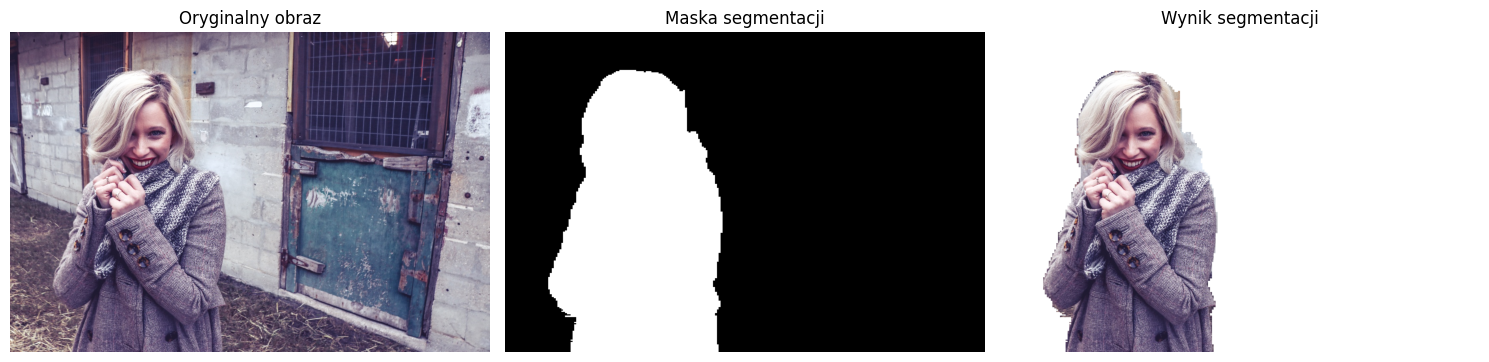

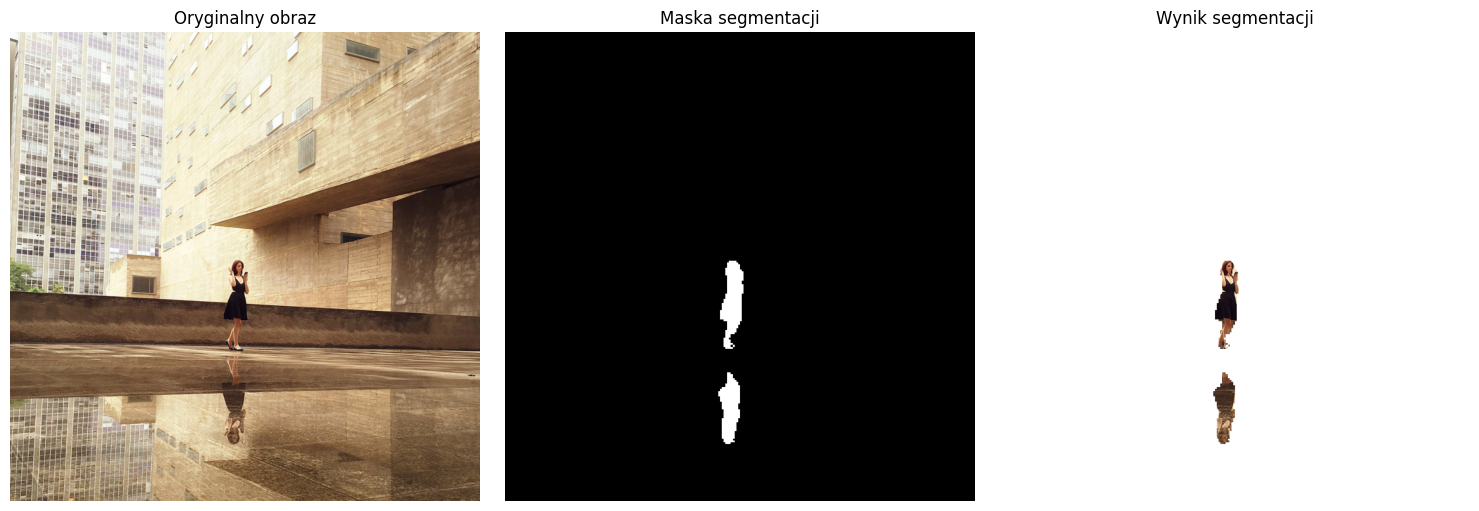

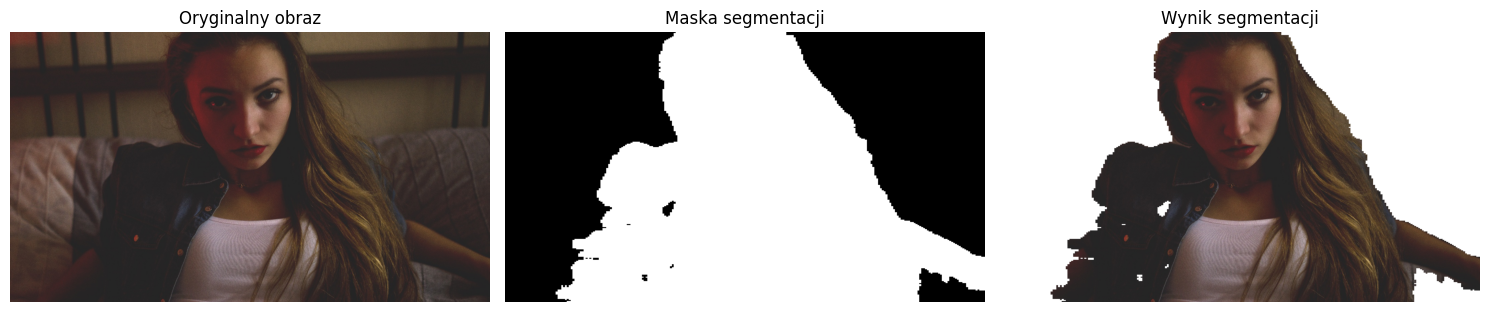

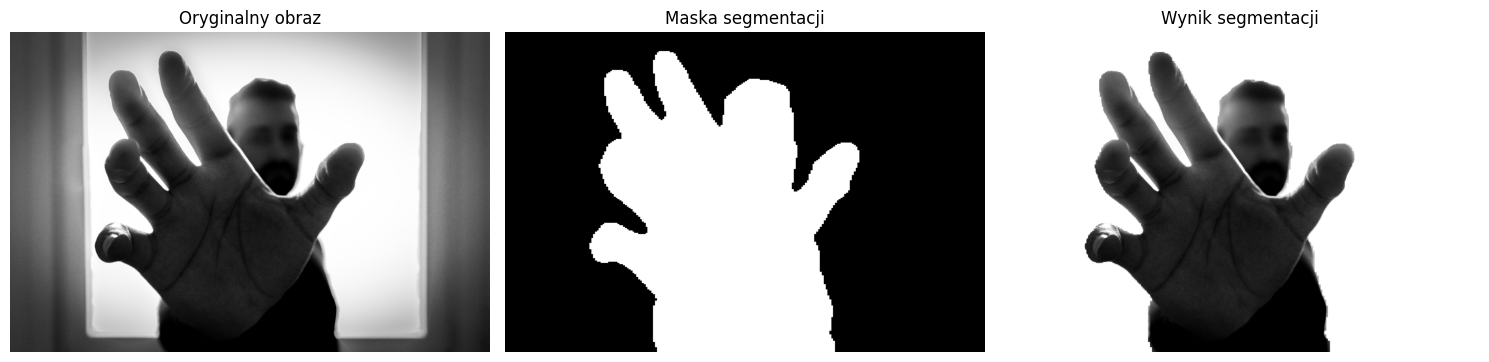

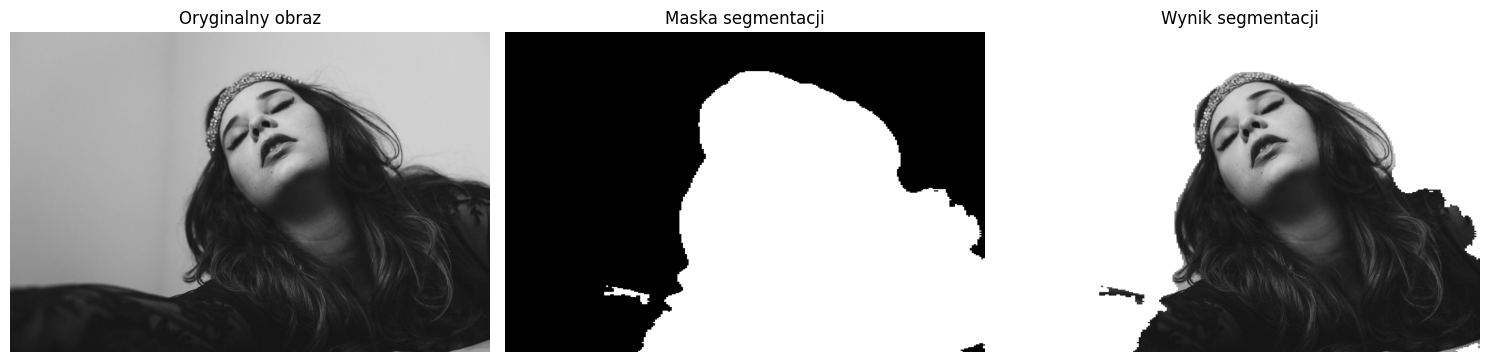

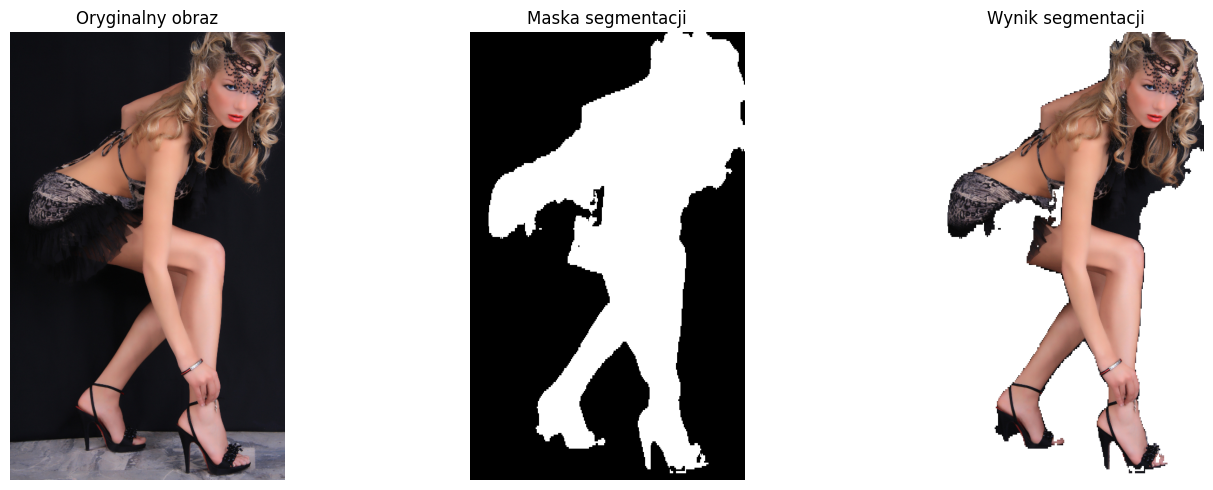

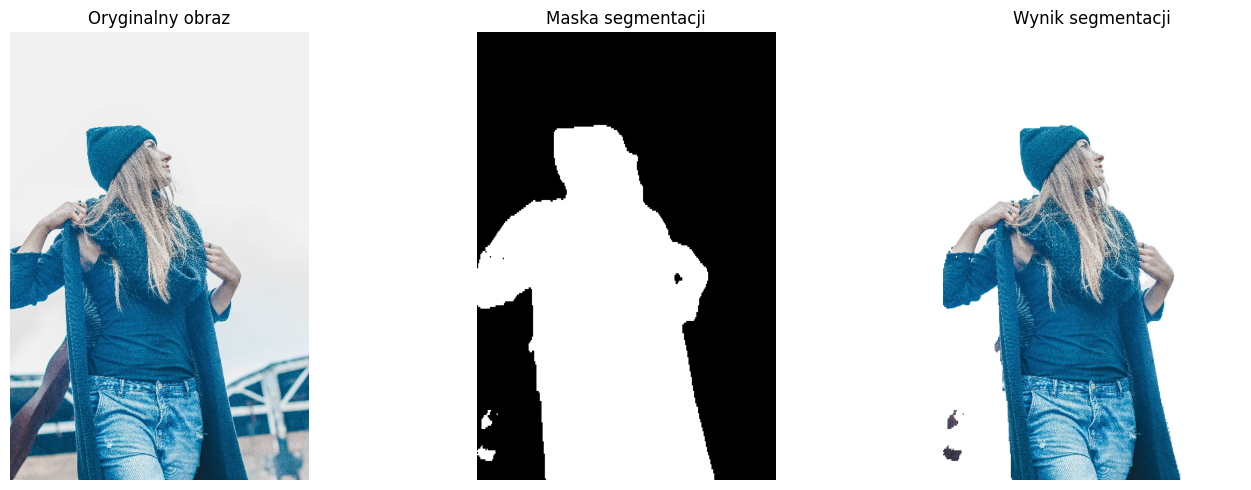

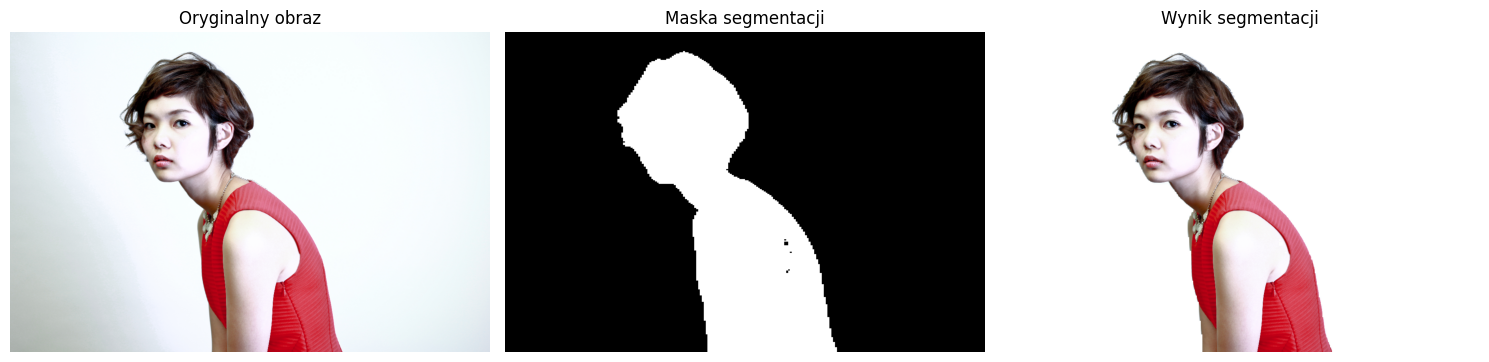

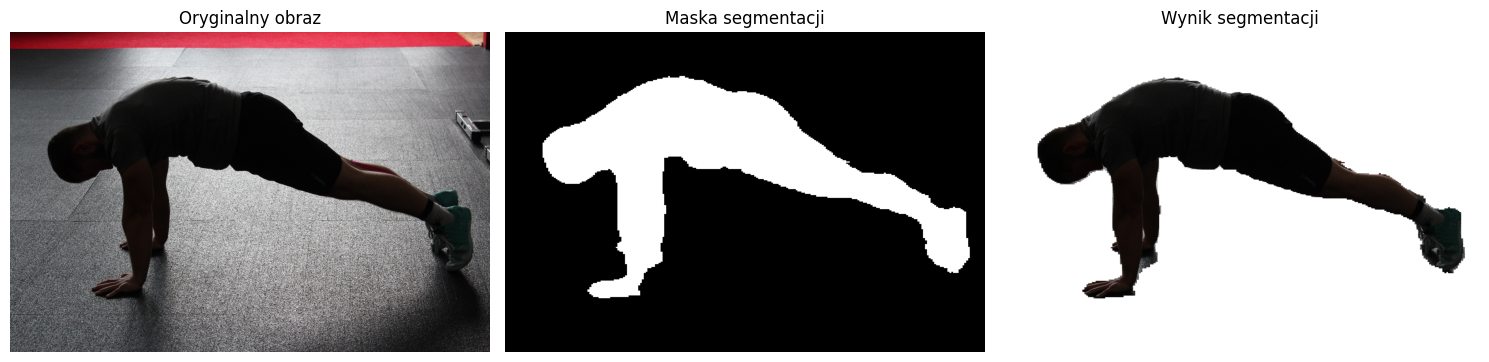

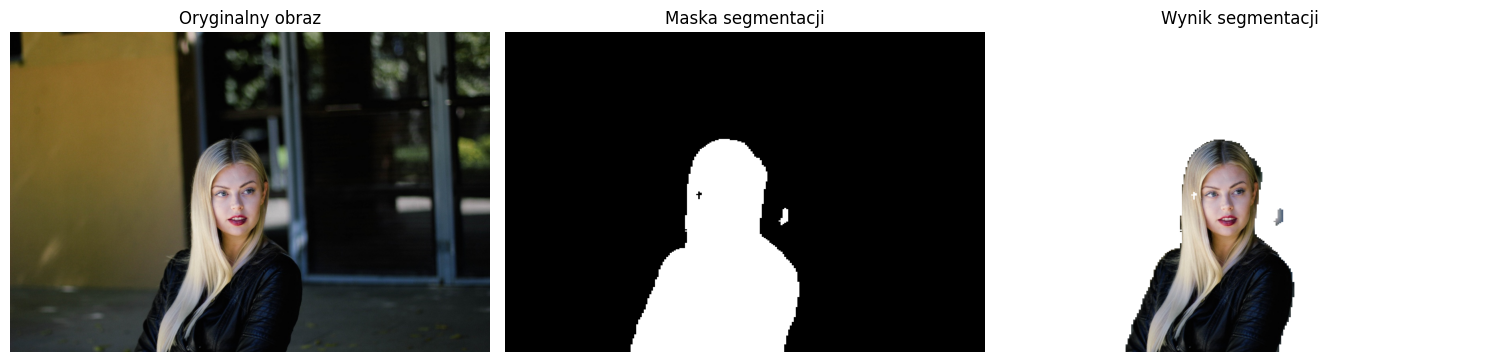

In [8]:
if __name__ == '__main__':
    main()